In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from pandas_summary import DataFrameSummary
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('../..')
from src import utils

In [2]:
DATA        = Path('data')
RAW         = DATA/'raw'
INTERIM     = DATA/'interim'
PROCESSED   = DATA/'processed'
SUBMISSIONS = DATA/'submissions'

In [3]:
from surprise import dump
_, svd = dump.load(PROCESSED/'svd.dump')
_, nmf = dump.load(PROCESSED/'nmf.dump')

In [4]:
week_labels = [20180226, 20180305, 20180312, 20180319, 
               20180326, 20180402, 20180409, 20180416, 20180423]

In [5]:
%%time
weeks = []
for name in week_labels:
    weeks.append(pd.read_feather(PROCESSED/f'week_{name % 10000:04}_diffscount.feather'))

CPU times: user 5.43 s, sys: 3.14 s, total: 8.57 s
Wall time: 15.4 s


## SVD features

In [6]:
uid = svd.trainset._raw2inner_id_users
iid = svd.trainset._raw2inner_id_items

In [7]:
user_bias = lambda x: svd.bu[uid[x]]
item_bias = lambda x: svd.bi[iid[x]]
recommend = lambda r: svd.predict(r.CustomerIdx, r.IsinIdx).est

In [8]:
%%time
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
for w in weeks:
    w['SVD_CustomerBias'] = w.CustomerIdx.apply(user_bias)
    w['SVD_IsinBias'] = w.IsinIdx.apply(item_bias)
    w['SVD_Recommend'] = w.apply(recommend, axis=1)

CPU times: user 2min 25s, sys: 6.6 s, total: 2min 31s
Wall time: 2min 26s


In [23]:
%%time
for n, w in zip(week_labels, weeks):
    print(n)
    customer_factors = np.array([svd.pu[uid[cIdx]] for cIdx in w.CustomerIdx])
    isin_factors = np.array([svd.qi[iid[iIdx]] for iIdx in w.IsinIdx])
    for i in range(customer_factors.shape[1]):
        w[f'SVD_CustomerFactor{i:02}'] = customer_factors[:,i]
    for i in range(isin_factors.shape[1]):
        w[f'SVD_IsinFactor{i:02}'] = isin_factors[:,i]

20180226
20180305
20180312
20180319
20180326
20180402
20180409
20180416
20180423
CPU times: user 6.88 s, sys: 768 ms, total: 7.64 s
Wall time: 7.64 s


In [25]:
%%time
for name, w in zip(week_labels, weeks):
    w.to_feather(PROCESSED/f'week_{name % 10000:04}_SVD_diffscount.feather')

CPU times: user 12.3 s, sys: 3.83 s, total: 16.1 s
Wall time: 17.6 s


## Preprocessing

In [26]:
from functools import cmp_to_key
from src.utils import composite_rating_cmp
isin       = pd.read_csv(RAW/'Isin.csv', low_memory=False)
ratings = list(isin.CompositeRating.value_counts().index)
ratings = sorted(ratings, key=cmp_to_key(composite_rating_cmp), reverse=True)
rank = {k: i for i, k in enumerate(ratings)}

In [27]:
%%time
for n, w in zip(week_labels, weeks):
    print(n)
    w['CompositeRating']  = w.CompositeRating.apply(lambda x: rank[x])

20180226
20180305
20180312
20180319
20180326
20180402
20180409
20180416
20180423
CPU times: user 2.51 s, sys: 300 ms, total: 2.81 s
Wall time: 2.79 s


In [28]:
cat_cols = ['BuySell', 'Sector', 'Subsector', 'Region_x', 'Country', 
            'TickerIdx', 'Seniority', 'Currency', 'ActivityGroup', 
            'Region_y', 'Activity', 'RiskCaptain', 'Owner', 
            'IndustrySector', 'IndustrySubgroup', 'MarketIssue', 'CouponType']

In [29]:
id_cols = ['TradeDateKey', 'CustomerIdx', 'IsinIdx']
target_col = 'CustomerInterest'
pred_col = 'PredictionIdx'

In [30]:
from src.utils import apply_cats
for col in cat_cols:
    weeks[-1][col] = weeks[-1][col].astype('category').cat.as_ordered()
for w in weeks[:-1]:
    apply_cats(w, weeks[-1])

for w in weeks:
    for col in cat_cols:
        w[col] = w[col].cat.codes

## Model

In [31]:
from src.utils import run_model
from lightgbm import LGBMClassifier
metric_names = ['auc']

In [32]:
for i, w in enumerate(weeks[1:]):
    train, val, test = weeks[i], w, weeks[-1]
    print(train['TradeDateKey'].unique(), 
          val['TradeDateKey'].unique(), 
          test['TradeDateKey'].unique())

[20180226] [20180305] [20180423]
[20180305] [20180312] [20180423]
[20180312] [20180319] [20180423]
[20180319] [20180326] [20180423]
[20180326] [20180402] [20180423]
[20180402] [20180409] [20180423]
[20180409] [20180416] [20180423]
[20180416] [20180423] [20180423]


In [33]:
%%time
results = None
output = []
for i, w in enumerate(weeks[1:]):
    train, val, test = weeks[i], weeks[-2], weeks[-1]
    X_train, y_train = train.drop(id_cols + [target_col], axis=1), \
                       train[target_col]
    if pred_col in val.columns: # when test acts as validation
        X_val, y_val = None, None
    else:
        X_val, y_val = val.drop(id_cols + [target_col], axis=1), \
                       val[target_col]
    X_test = test.drop(id_cols + [target_col, pred_col], axis=1)
        
    y_test, _, results, model = run_model(
            LGBMClassifier(n_estimators=100),
            X_train, y_train, X_val, y_val, X_test,
            metric_names, results, 
            params_desc='n_estimators=100',
            dataset_desc=f'{week_labels[i]}_diffcounts', 
            early_stopping=False)
    output.append([y_test, model])

LGBMClassifier 

[1]	valid_0's auc: 0.604425
[2]	valid_0's auc: 0.619793
[3]	valid_0's auc: 0.618233
[4]	valid_0's auc: 0.608988
[5]	valid_0's auc: 0.61618
[6]	valid_0's auc: 0.616763
[7]	valid_0's auc: 0.625288
[8]	valid_0's auc: 0.620176
[9]	valid_0's auc: 0.622561
[10]	valid_0's auc: 0.626981
[11]	valid_0's auc: 0.627187
[12]	valid_0's auc: 0.626148
[13]	valid_0's auc: 0.625765
[14]	valid_0's auc: 0.62559
[15]	valid_0's auc: 0.627287
[16]	valid_0's auc: 0.627553
[17]	valid_0's auc: 0.626757
[18]	valid_0's auc: 0.627582
[19]	valid_0's auc: 0.626636
[20]	valid_0's auc: 0.62912
[21]	valid_0's auc: 0.62825
[22]	valid_0's auc: 0.630192
[23]	valid_0's auc: 0.630047
[24]	valid_0's auc: 0.629869
[25]	valid_0's auc: 0.629399
[26]	valid_0's auc: 0.630899
[27]	valid_0's auc: 0.628404
[28]	valid_0's auc: 0.627404
[29]	valid_0's auc: 0.627087
[30]	valid_0's auc: 0.627545
[31]	valid_0's auc: 0.62775
[32]	valid_0's auc: 0.6277
[33]	valid_0's auc: 0.627011
[34]	valid_0's auc: 0.627285
[35]	valid_0'

In [34]:
results

,dataset,model,params,time,trn_auc_mean,val_auc_mean
0,20180226_diffcounts,LGBMClassifier,n_estimators=100,12.58,0.824834,0.620656
1,20180305_diffcounts,LGBMClassifier,n_estimators=100,10.12,0.800487,0.658066
2,20180312_diffcounts,LGBMClassifier,n_estimators=100,10.49,0.796927,0.689172
3,20180319_diffcounts,LGBMClassifier,n_estimators=100,10.85,0.818795,0.693913
4,20180326_diffcounts,LGBMClassifier,n_estimators=100,11.89,0.846076,0.675948
5,20180402_diffcounts,LGBMClassifier,n_estimators=100,10.65,0.833802,0.735758
6,20180409_diffcounts,LGBMClassifier,n_estimators=100,10.00,0.835371,0.764902
7,20180416_diffcounts,LGBMClassifier,n_estimators=100,10.11,0.844362,0.844362


In [35]:
# first 5 predictions (2018 data)
np.array([x[0] for x in output])[:,:5]

array([[0.04081251, 0.14106889, 0.02571792, 0.00875383, 0.01805315],
       [0.05379026, 0.15155855, 0.0301512 , 0.02617993, 0.01649775],
       [0.03493692, 0.06823365, 0.02591871, 0.03832126, 0.0230947 ],
       [0.0306454 , 0.06881223, 0.02716014, 0.01795705, 0.01200714],
       [0.03467033, 0.0762789 , 0.02531351, 0.00680751, 0.01490136],
       [0.04696389, 0.07896781, 0.02835674, 0.02779406, 0.02840502],
       [0.05925707, 0.1061074 , 0.03469189, 0.03497569, 0.0251718 ],
       [0.03156942, 0.04251421, 0.03327561, 0.03012182, 0.04026618]])

In [36]:
test[target_col] = np.mean([x[0] for x in output], axis=0)

## Submission

In [37]:
submission = pd.read_csv(RAW/'sample_submission.csv', low_memory=False)
submission = pd.merge(submission[['PredictionIdx']], test[['PredictionIdx', target_col]], 
                      how='left', on='PredictionIdx')

In [38]:
submission[target_col].describe()

count    484758.000000
mean          0.029743
std           0.031607
min           0.002169
25%           0.012700
50%           0.022973
75%           0.037537
max           0.861370
Name: CustomerInterest, dtype: float64

In [39]:
submission.head()

,PredictionIdx,CustomerInterest
0,a1e0d80784,0.041581
1,c2cc6cc2a8,0.091693
2,a8e94f6344,0.028823
3,758bae1e35,0.023864
4,02ab378ee8,0.022300


In [40]:
submission.to_csv(SUBMISSIONS/'18-lgbm_8weeks_SVD_diffscounts_0226-0416.csv', index=False)

## Feature importance

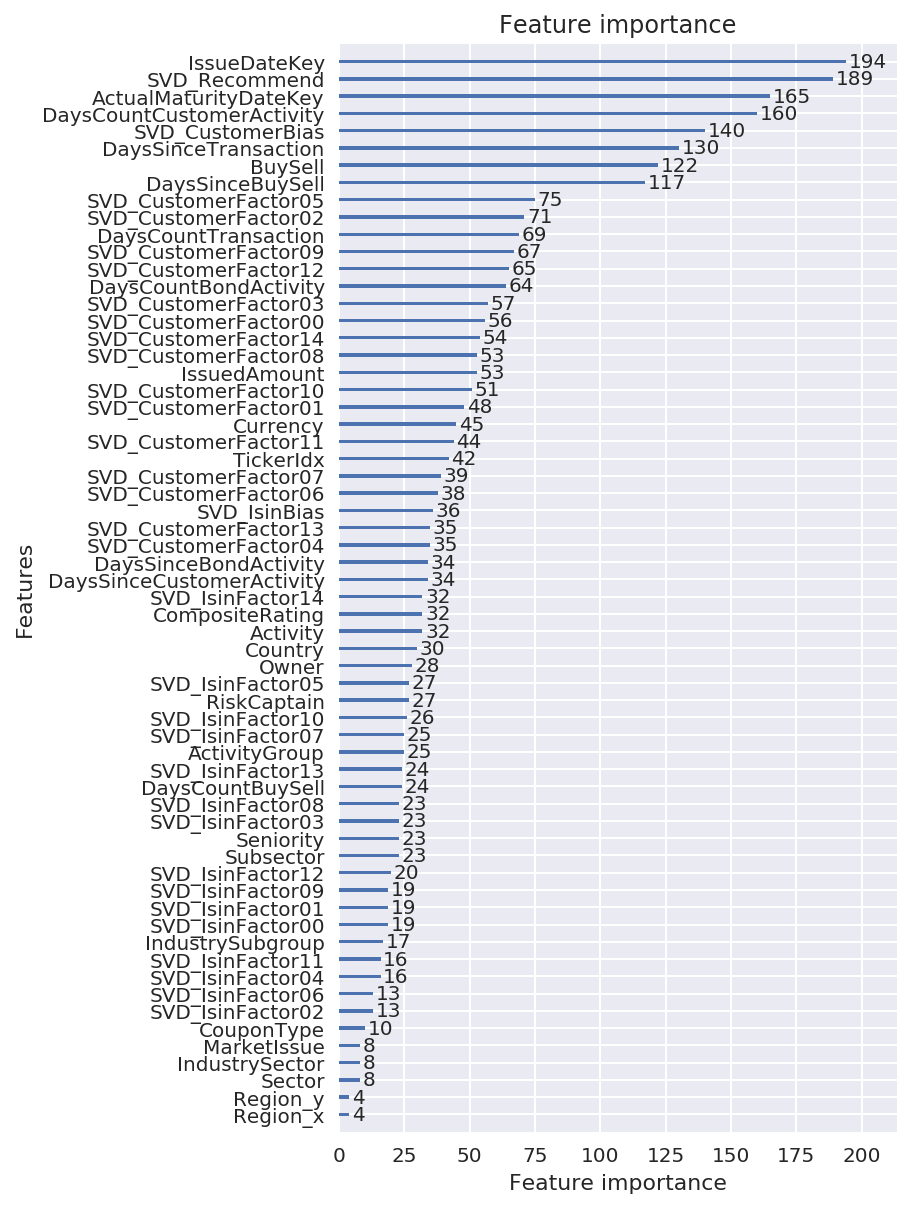

In [43]:
from lightgbm import plot_importance
plot_importance(output[0][1], figsize=(5,10))

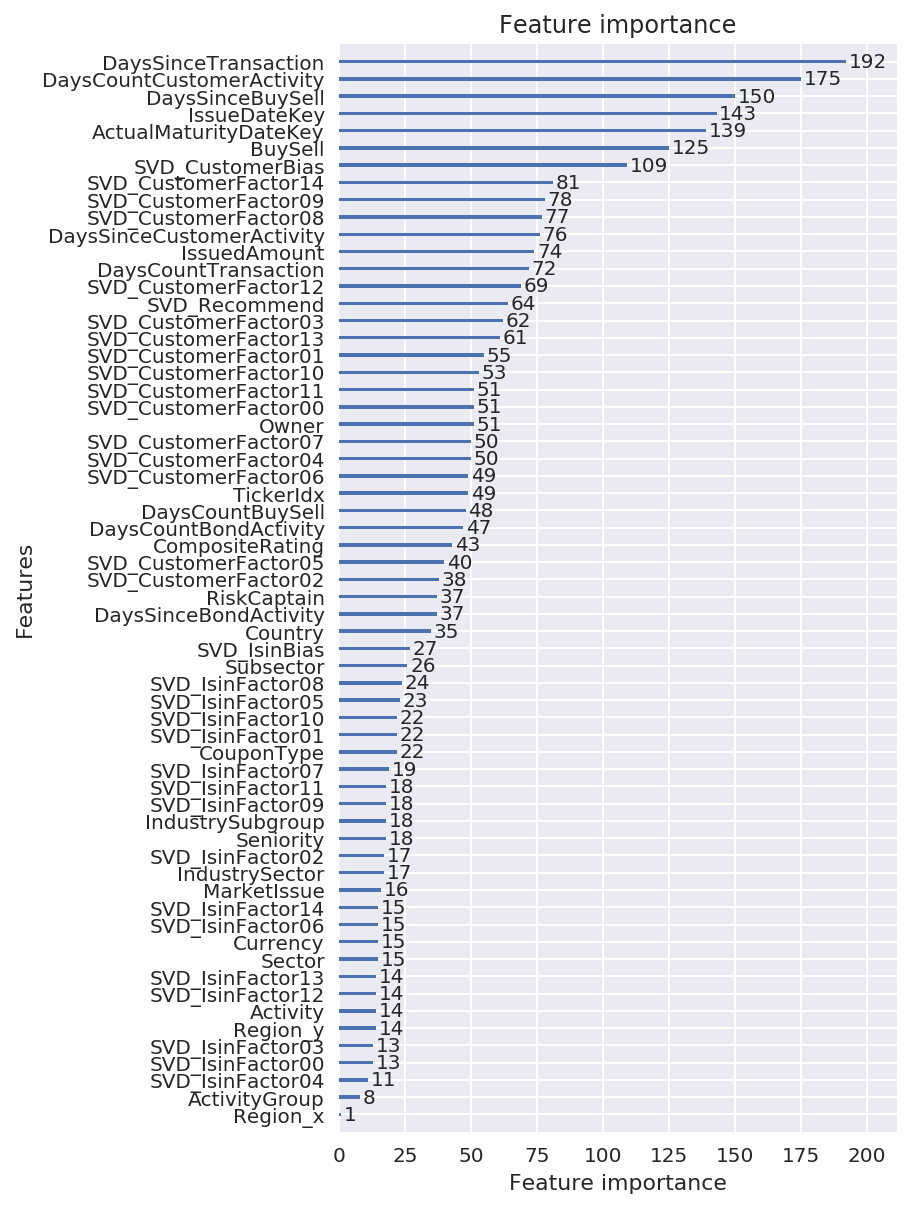

In [44]:
plot_importance(output[-1][1], figsize=(5, 10))